# Analyse avec K-means

**But :** Trouver les différents clusters depuis les images précédements extraites des vidéos

In [1]:
from os import listdir
from pathlib import Path
import shutil

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms as T
from torchvision.io import read_image
import torchvision

from sklearn.cluster import KMeans
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import silhouette_samples, silhouette_score

import skimage.transform

/media/HDD/planaire_classification/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset

In [2]:
img_path = "../data/images_croped_color/all/"

In [6]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None, device='cpu'):
        self.img_dir = img_dir
        self.imgs_path = [f"{img_dir}/{img}" for img in listdir(self.img_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.imgs_path)

    def __getitem__(self, idx):
        img_path = self.imgs_path[idx]
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image).to(device)
        return image

In [7]:
mean  = [0.6837, 0.6463, 0.5815]
std = [0.1203, 0.1112, 0.1055]

transform = T.Compose([
                        T.Resize((224,224)),
                        T.ConvertImageDtype(dtype=torch.float32),
                        T.Normalize(mean=mean, std=std)
                    ])

In [3]:
img_path = '../data/hymenoptera_data'

In [5]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None, device='cpu'):
        self.img_dir = img_dir
        self.imgs_path = [f"{img_dir}/{img}" for img in listdir(self.img_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.imgs_path)

    def __getitem__(self, idx):
        img_path = self.imgs_path[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image).to(device)
        return image

In [5]:
transform = T.Compose([T.Resize((224,224)), 
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

### CNN

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
dataset = ImageDataset(img_dir=img_path, transform=transform, device=device)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

In [10]:
len(dataset)

3761

In [38]:
# img = dataset[25]
# plt.imshow(img)

listdir(img_path)[25]

'imageNotFound.gif'

In [11]:
vgg16_model = torchvision.models.vgg16(pretrained=True)

vgg16_model.to(device)

for param in vgg16_model.parameters():
    param.requires_grad = False

In [12]:
dataloader_iter = iter(dataloader)

In [13]:
#activation = {}
activation = []
def get_activation(name):
    def hook(model, input, output):
        #activation[name] = output.detach()
        activation.append(output.detach().cpu().numpy())
        #activation[name] = np.concatenate((activation[name], output.detach().cpu().numpy()), axis=0)

    return hook

In [14]:
vgg16_model.classifier[0].register_forward_hook(get_activation('classifier0'))
vgg16_model.eval()

res = []
for features in dataloader_iter:
    vgg16_model(features.float())
    
res = np.concatenate(activation, axis=0)

In [15]:
res.shape

(3761, 4096)

### ACP

In [16]:
ipca = IncrementalPCA(n_components=50, batch_size=100)
X_ipca = ipca.fit_transform(res)
var = ipca.explained_variance_ratio_.cumsum()

In [17]:
X_ipca.shape

(3761, 50)

variance preserved by 50 components: 0.800


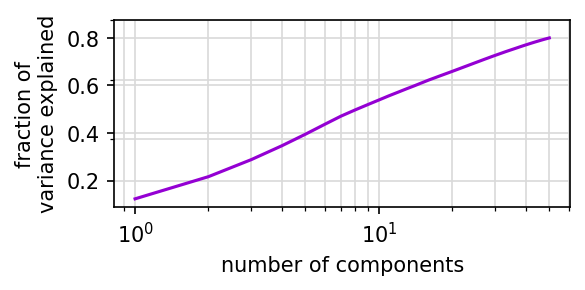

In [18]:


fig, ax = plt.subplots(figsize=(4,2),dpi=150,)
ax.grid('on', which='both', color=np.ones(3)*0.85)
ax.plot(range(1,len(var)+1), var, color='darkviolet')
ax.set_xscale('log')
ax.set_xlabel('number of components')
ax.set_ylabel('fraction of\nvariance explained')

yt=np.linspace(1/4, 1, 4)
ytm = [np.mean([yt[i], yt[i+1]]) for i in range(len(yt)-1)]
ax.set_yticks(ytm, minor=True)


fig.tight_layout()
print('variance preserved by 50 components: {:.3f}'.format(var[49]))

### Clustering

Determiner les K clusters avec TSNE

In [19]:
def find_k_clusters(range_max, X, full_graph=True):
    range_n_clusters = range(2, range_max)
    
    silhouette_scores = []
    best_avg_silh = 0
    optimal_clusters = 2

    for n_clusters in range_n_clusters:
        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=30, max_iter=600)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        if silhouette_avg > best_avg_silh:
            best_avg_silh = silhouette_avg
            optimal_clusters = n_clusters


        silhouette_scores.append(silhouette_avg)

        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )


        if full_graph:
            # Create a subplot with 1 row and 2 columns
            fig, (ax1, ax2) = plt.subplots(1, 2)
            fig.set_size_inches(18, 7)

            # The 1st subplot is the silhouette plot
            # The silhouette coefficient can range from -1, 1 but in this example all
            # lie within [-0.1, 1]
            ax1.set_xlim([-0.1, 1])
            # The (n_clusters+1)*10 is for inserting blank space between silhouette
            # plots of individual clusters, to demarcate them clearly.
            ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

            # Compute the silhouette scores for each sample
            sample_silhouette_values = silhouette_samples(X, cluster_labels)

            y_lower = 10
            for i in range(n_clusters):
                # Aggregate the silhouette scores for samples belonging to
                # cluster i, and sort them
                ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

                ith_cluster_silhouette_values.sort()

                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i

                color = cm.nipy_spectral(float(i) / n_clusters)
                ax1.fill_betweenx(
                    np.arange(y_lower, y_upper),
                    0,
                    ith_cluster_silhouette_values,
                    facecolor=color,
                    edgecolor=color,
                    alpha=0.7,
                )

                # Label the silhouette plots with their cluster numbers at the middle
                ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                # Compute the new y_lower for next plot
                y_lower = y_upper + 10  # 10 for the 0 samples

            ax1.set_title("The silhouette plot for the various clusters.")
            ax1.set_xlabel("The silhouette coefficient values")
            ax1.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the values
            ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

            ax1.set_yticks([])  # Clear the yaxis labels / ticks
            ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

            # 2nd Plot showing the actual clusters formed
            colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
            ax2.scatter(
                X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
            )

            # Labeling the clusters
            centers = clusterer.cluster_centers_
            # Draw white circles at cluster centers
            ax2.scatter(
                centers[:, 0],
                centers[:, 1],
                marker="o",
                c="white",
                alpha=1,
                s=200,
                edgecolor="k",
            )

            for i, c in enumerate(centers):
                ax2.scatter(c[0], c[1], marker="$%d$" %
                            i, alpha=1, s=50, edgecolor="k")

            ax2.set_title("The visualization of the clustered data.")
            ax2.set_xlabel("Feature space for the 1st feature")
            ax2.set_ylabel("Feature space for the 2nd feature")

            plt.suptitle(
                "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
                % n_clusters,
                fontsize=14,
                fontweight="bold",
            )

    if full_graph:
        plt.show()

    fig, ax = plt.subplots()
    y_pos = np.arange(2, len(silhouette_scores)+2)
    ax.bar(y_pos, silhouette_scores)
    ax.set_xlabel('Nombre de clusters')
    ax.set_ylabel('Score de silhouette')
    ax.set_title('Score de silhouette par cluster')
    plt.show()
    
    return optimal_clusters


In [34]:
def get_k_clusters(range_max, X):
    range_n_clusters = range(2, range_max)

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=30, max_iter=600)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor="k",
        )

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker="$%d$" %
                        i, alpha=1, s=50, edgecolor="k")

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()


For n_clusters = 2 The average silhouette_score is : 0.12397314014458093
For n_clusters = 3 The average silhouette_score is : 0.106465144571876
For n_clusters = 4 The average silhouette_score is : 0.10132712520980809
For n_clusters = 5 The average silhouette_score is : 0.10493483726282228
For n_clusters = 6 The average silhouette_score is : 0.10734970494525856
For n_clusters = 7 The average silhouette_score is : 0.11232472844707249
For n_clusters = 8 The average silhouette_score is : 0.11309758456266232
For n_clusters = 9 The average silhouette_score is : 0.11569030076089502
For n_clusters = 10 The average silhouette_score is : 0.1221248750065363
For n_clusters = 11 The average silhouette_score is : 0.12363007905829644


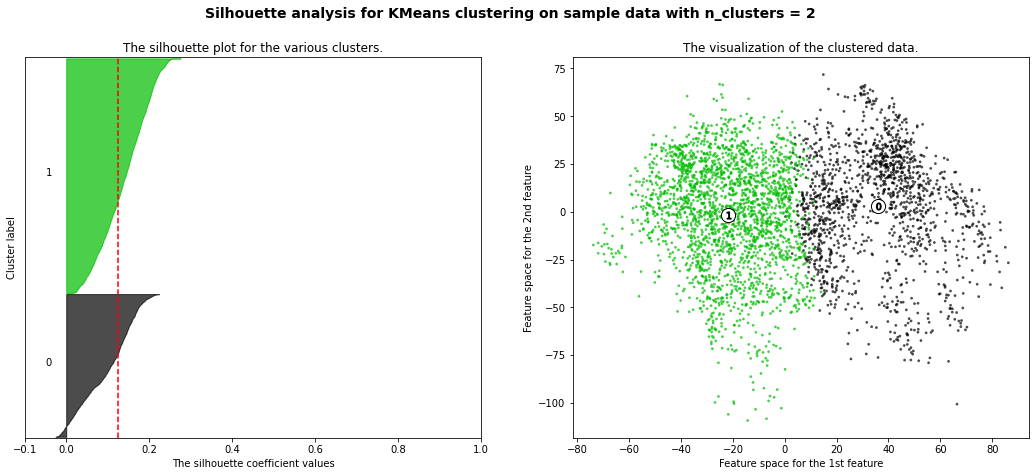

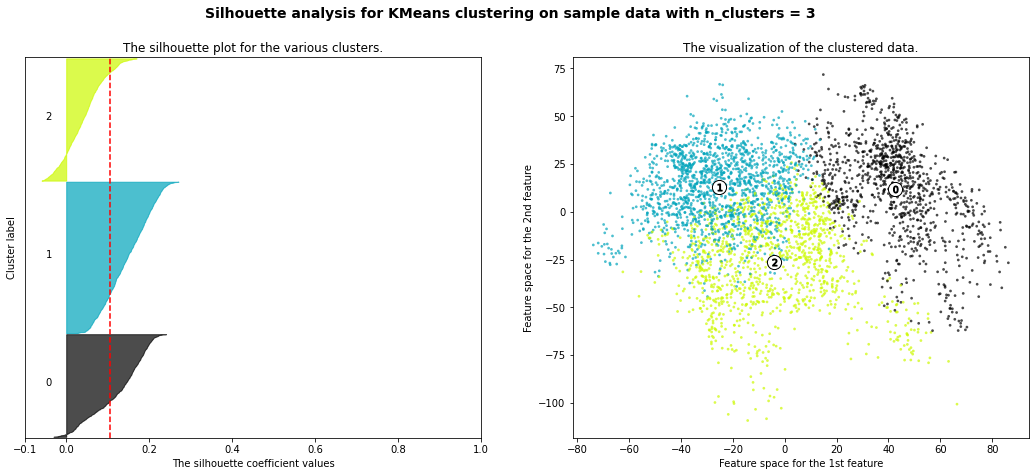

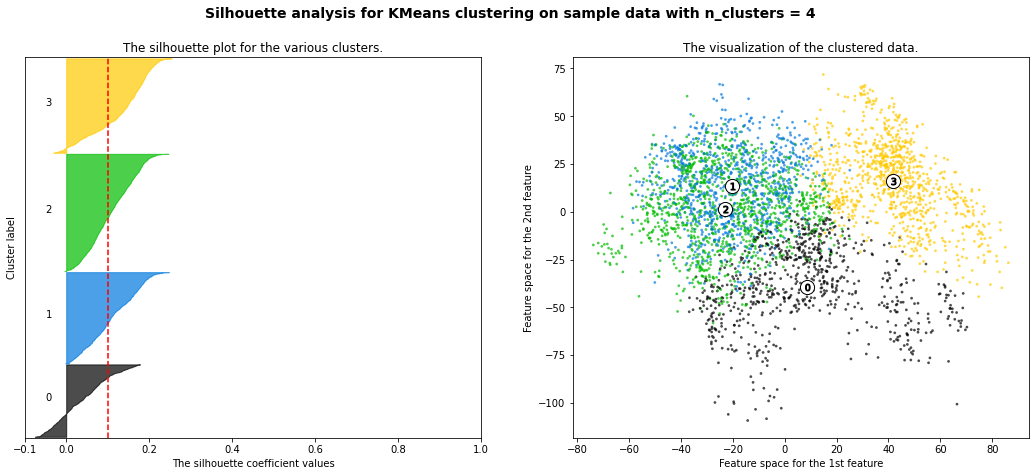

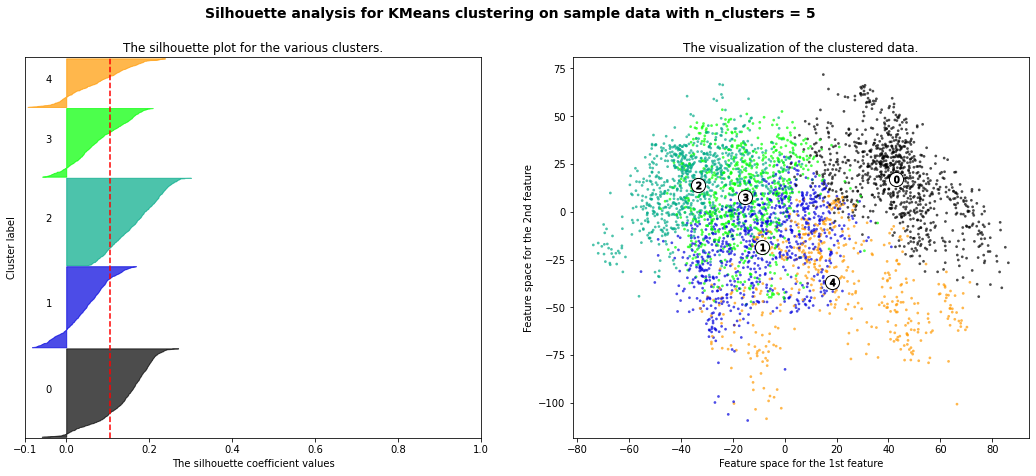

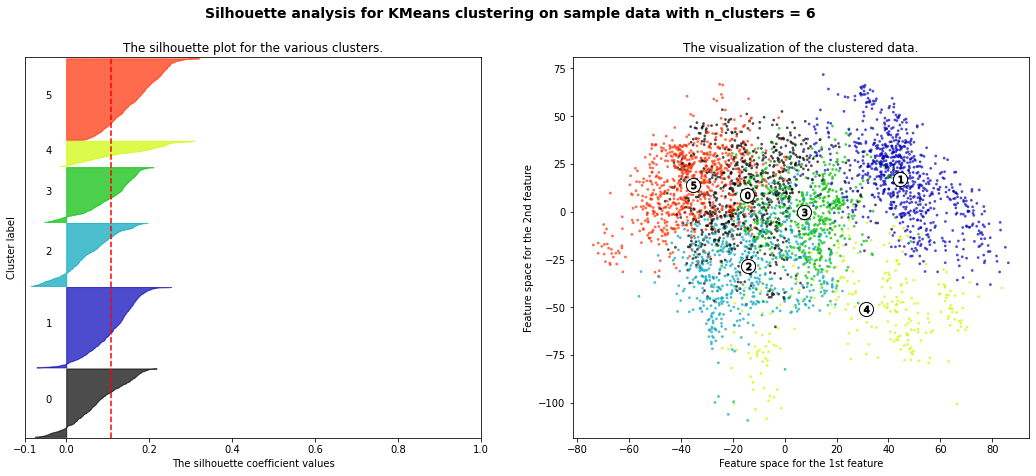

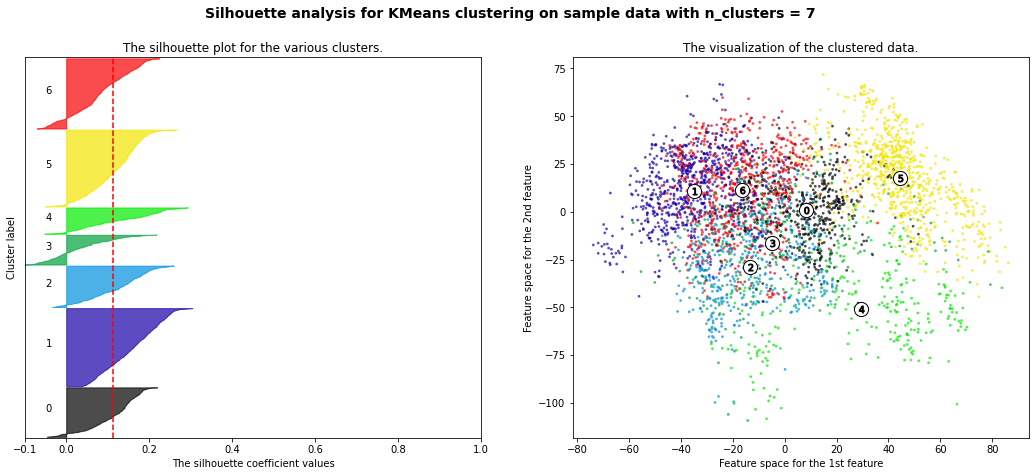

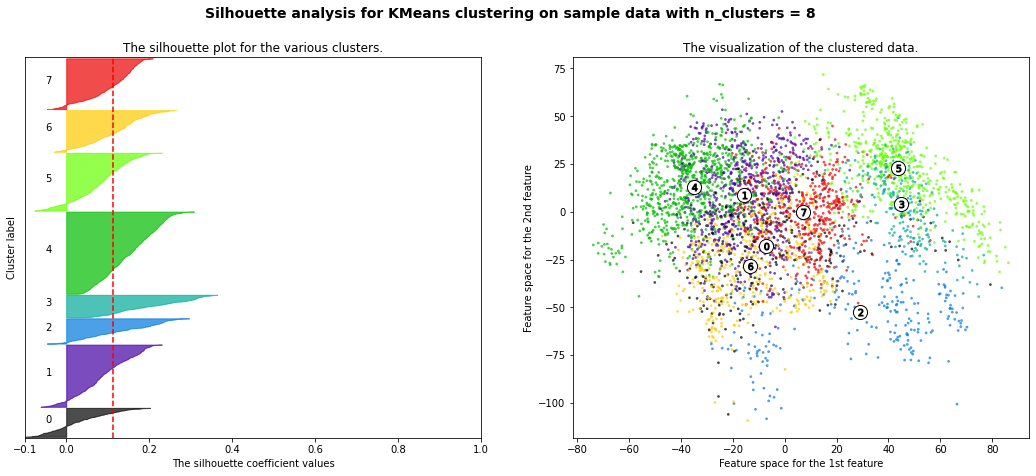

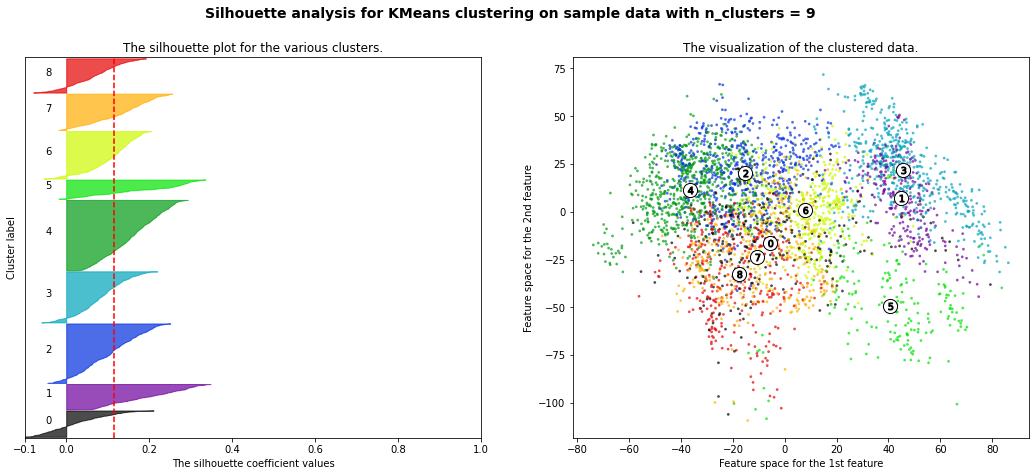

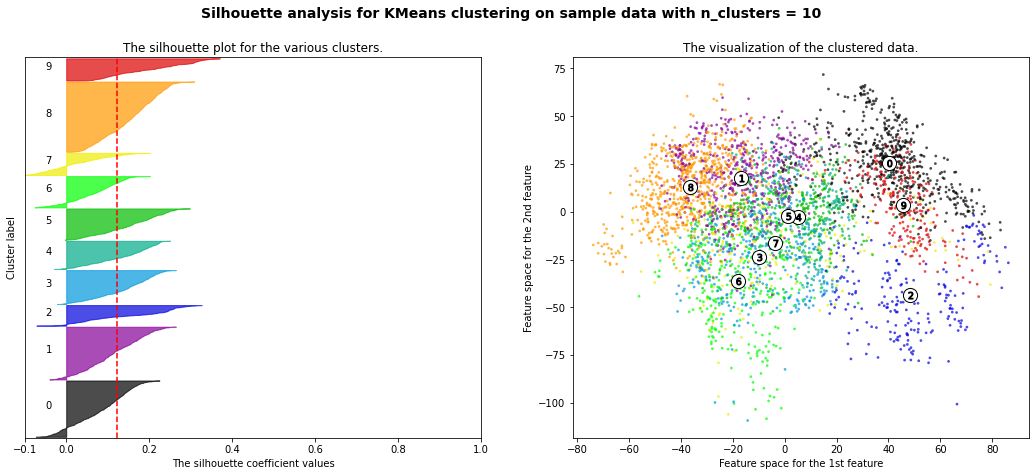

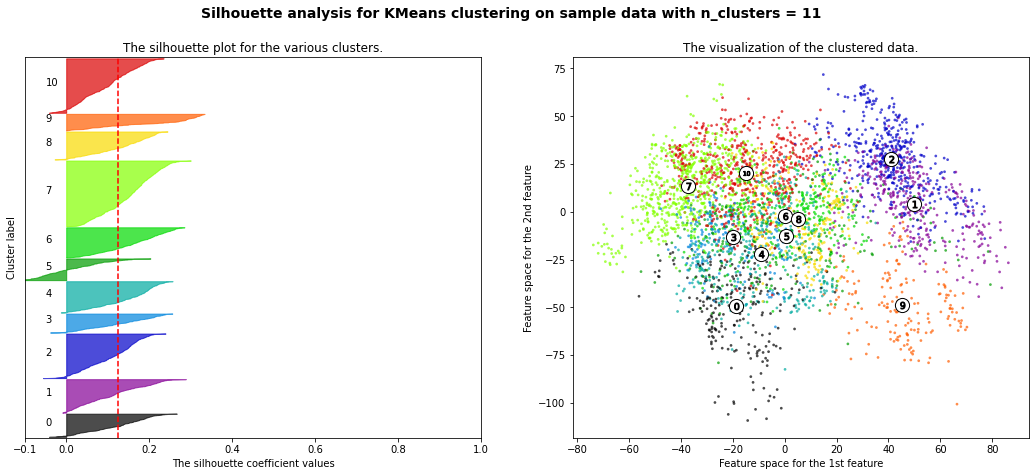

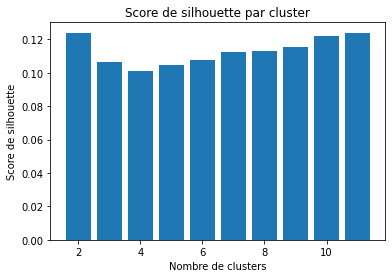

In [20]:
optimal_clusters = find_k_clusters(12, X_ipca)

In [21]:
def extract_clusters(img_path, nb_cluster, cluster_labels):
    result_path = "../cnn_clustering_hymenoptera"
    files = listdir(img_path)
    
    for i in range(nb_cluster):
        Path(f"{result_path}/{i}").mkdir(parents=True, exist_ok=True)
    
    for idx, label in enumerate(cluster_labels):
        img_name = files[idx]
        shutil.copyfile(f"{img_path}/{img_name}",f"{result_path}/{label}/{img_name}")

In [23]:
clusterer = KMeans(n_clusters=optimal_clusters, init='k-means++', n_init=30, max_iter=600)
cluster_labels = clusterer.fit_predict(X_ipca)
extract_clusters(img_path, optimal_clusters, cluster_labels)